📚 Import Required Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Run functions eagerly (useful for debugging with TensorFlow)
tf.config.run_functions_eagerly(True)

# Keras layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    Conv2D,
    ZeroPadding2D,
    LeakyReLU,
    UpSampling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

%matplotlib inline

⚙️ Define Parameters

In [ ]:
# Image dimensions (28x28 grayscale)
img_shape = (28, 28, 1)

# Dimension of random noise vector (latent space)
latent_dim = 100

# Number of channels (grayscale = 1)
channels = 1

🧵 Download and Visualize the Fashion-MNIST Dataset

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


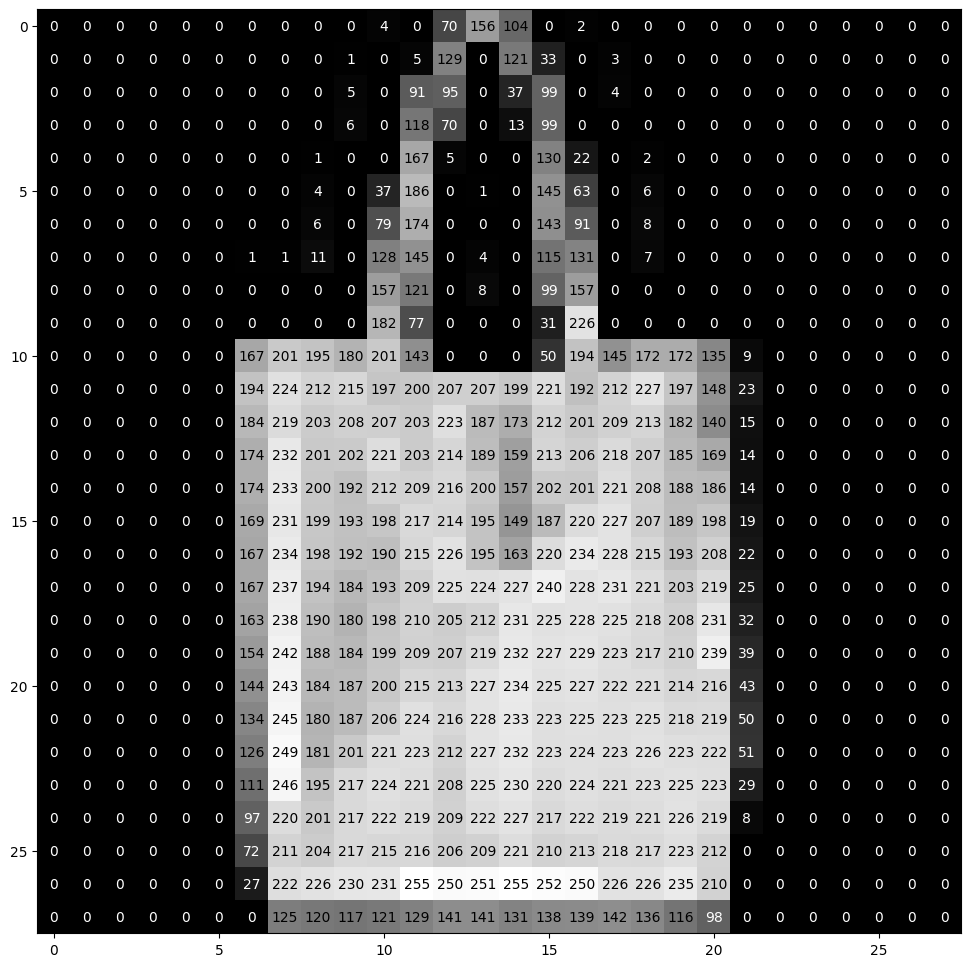

In [ ]:
# Load only the training set (we don't need labels for GAN training)
(training_data, _), (_, _) = fashion_mnist.load_data()


# Function to visualize pixel values on top of the image
def visualize_input(img, ax):
    ax.imshow(img, cmap="gray")
    thresh = img.max() / 2.5
    width, height = img.shape
    for x in range(width):
        for y in range(height):
            ax.annotate(
                text=str(round(img[x][y], 2)),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if img[x][y] < thresh else "black",
            )


# Display a sample image with pixel values
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

🔄 Preprocess Dataset (Rescale to [-1, 1])

In [ ]:
# Normalize pixel values from [0, 255] → [-1, 1]
x_train = (training_data / 127.5) - 1

# Expand dimensions to (28,28,1)
x_train = np.expand_dims(x_train, axis=3)
print(x_train.shape)

(60000, 28, 28, 1)


🧑‍🎨 Build Generator Model

In [ ]:
def build_generator():
    # Input: random noise vector
    noise = Input(shape=(latent_dim,))

    # Fully connected layer to reshape noise into feature maps
    x = Dense(128 * 7 * 7, activation="relu")(noise)
    x = Reshape((7, 7, 128))(x)
    x = UpSampling2D()(x)  # Upsample to 14x14

    # Convolutional layers with batch normalization
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    x = UpSampling2D()(x)  # Upsample to 28x28

    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)

    # Final output layer (tanh → values in [-1, 1])
    x = Conv2D(channels, kernel_size=3, padding="same")(x)
    img = Activation("tanh")(x)

    return Model(inputs=noise, outputs=img)

🕵️ Build Discriminator Model

In [ ]:
def build_discriminator():
    # Input: image (28x28x1)
    img = Input(shape=img_shape)

    # Convolutional layers with LeakyReLU and Dropout
    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(img)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)  # Maintain shape
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.25)(x)

    # Flatten and output probability (real/fake)
    x = Flatten()(x)
    validity = Dense(1, activation="sigmoid")(x)

    return Model(inputs=img, outputs=validity)

🔗 Build and Compile Combined GAN

In [ ]:
# Define optimizers for generator & discriminator
opt_disc = Adam(learning_rate=0.0002, beta_1=0.5)
opt_gen = Adam(learning_rate=0.0002, beta_1=0.5)

# Initialize discriminator
discriminator = build_discriminator()
discriminator.summary()

# Initialize generator
generator = build_generator()
generator.summary()

# Compile discriminator separately
discriminator.compile(
    loss="binary_crossentropy", optimizer=opt_disc, metrics=["accuracy"]
)

# Create combined GAN (generator + discriminator)
z = Input(shape=(latent_dim,))
img = generator(z)

# Freeze discriminator for combined training
discriminator.trainable = False

# Discriminator predicts validity of generated image
validity = discriminator(img)

# Combined model trains generator to fool the discriminator
combined_model = Model(inputs=z, outputs=validity)
combined_model.compile(loss="binary_crossentropy", optimizer=opt_gen)

# Optionally recompile discriminator with new optimizer
discriminator.trainable = True
new_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(
    loss="binary_crossentropy", optimizer=new_optimizer, metrics=["accuracy"]
)

🖼️ Helper Function to Plot Generated Images

In [ ]:
def plot_generated_images(
    epoch, generator, examples=100, dim=(10, 10), fig_size=(10, 10)
):
    # Generate random noise
    noise = np.random.normal(loc=0, scale=1, size=(examples, latent_dim))
    generated_images = generator.predict(noise, verbose=0)
    generated_images = generated_images.reshape(examples, 28, 28)

    # Plot and save generated images
    plt.figure(figsize=fig_size)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"dcgan_output/gan_generated_image_epoch_{epoch}.png")

🏋️ Define Training Function

In [ ]:
def train(epochs, batch_size=128, save_interval=50):

    # Labels for real (1) and fake (0) images
    valid = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))

    for epoch in range(epochs):

        # -------------------------
        #  Train Discriminator
        # -------------------------

        # Sample a batch of real images
        idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        imgs = x_train[idx]

        # Generate fake images
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        gen_imgs = generator.predict(noise, verbose=0)

        # Train discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(x=imgs, y=valid)
        d_loss_fake = discriminator.train_on_batch(x=gen_imgs, y=fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # -------------------------
        #  Train Generator
        # -------------------------

        # Generator wants discriminator to classify generated images as real
        g_loss = combined_model.train_on_batch(x=noise, y=valid)

        # Print training progress
        print(
            f"{epoch} [D loss: {d_loss[0]:.6f}, acc.: {d_loss[1]*100:.2f}%] "
            f"[G loss: {g_loss:.6f}]"
        )

        # Save generated images at intervals
        if epoch % save_interval == 0:
            generator.save("dcgan_output/generator.keras")
            discriminator.save("dcgan_output/discriminator.keras")
            plot_generated_images(epoch, generator)

🚀 Train the GAN Model

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
14001 [D loss: 0.958657, acc.: 50.40%] [G loss: 0.392529]
14002 [D loss: 0.958747, acc.: 50.40%] [G loss: 0.392506]
14003 [D loss: 0.958804, acc.: 50.40%] [G loss: 0.392524]
14004 [D loss: 0.958829, acc.: 50.40%] [G loss: 0.392506]
14005 [D loss: 0.958831, acc.: 50.40%] [G loss: 0.392538]
14006 [D loss: 0.958846, acc.: 50.40%] [G loss: 0.392526]
14007 [D loss: 0.958869, acc.: 50.40%] [G loss: 0.392531]
14008 [D loss: 0.958879, acc.: 50.40%] [G loss: 0.392524]
14009 [D loss: 0.958892, acc.: 50.40%] [G loss: 0.392514]
14010 [D loss: 0.958916, acc.: 50.40%] [G loss: 0.392539]
14011 [D loss: 0.958929, acc.: 50.40%] [G loss: 0.392511]
14012 [D loss: 0.958939, acc.: 50.40%] [G loss: 0.392517]
14013 [D loss: 0.958973, acc.: 50.40%] [G loss: 0.392525]
14014 [D loss: 0.959003, acc.: 50.40%] [G loss: 0.392522]
14015 [D loss: 0.959033, acc.: 50.40%] [G loss: 0.392589]
14016 [D loss: 0.959033, acc.: 50.40%] [G loss: 0.392592]
14017 [D loss: 0.9590

/tmp/ipython-input-9-2260488890.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=fig_size)


19001 [D loss: 1.053967, acc.: 50.45%] [G loss: 0.424915]
19002 [D loss: 1.053968, acc.: 50.45%] [G loss: 0.424930]
19003 [D loss: 1.053992, acc.: 50.45%] [G loss: 0.424908]
19004 [D loss: 1.054007, acc.: 50.45%] [G loss: 0.424902]
19005 [D loss: 1.054010, acc.: 50.45%] [G loss: 0.424910]
19006 [D loss: 1.054009, acc.: 50.45%] [G loss: 0.424903]
19007 [D loss: 1.054014, acc.: 50.45%] [G loss: 0.424912]
19008 [D loss: 1.054036, acc.: 50.45%] [G loss: 0.424910]
19009 [D loss: 1.054041, acc.: 50.45%] [G loss: 0.424921]
19010 [D loss: 1.054046, acc.: 50.45%] [G loss: 0.424914]
19011 [D loss: 1.054055, acc.: 50.45%] [G loss: 0.424909]
19012 [D loss: 1.054071, acc.: 50.45%] [G loss: 0.424928]
19013 [D loss: 1.054092, acc.: 50.45%] [G loss: 0.424933]
19014 [D loss: 1.054101, acc.: 50.45%] [G loss: 0.424977]
19015 [D loss: 1.054110, acc.: 50.45%] [G loss: 0.424976]
19016 [D loss: 1.054107, acc.: 50.45%] [G loss: 0.425018]
19017 [D loss: 1.054141, acc.: 50.45%] [G loss: 0.425015]
19018 [D loss:

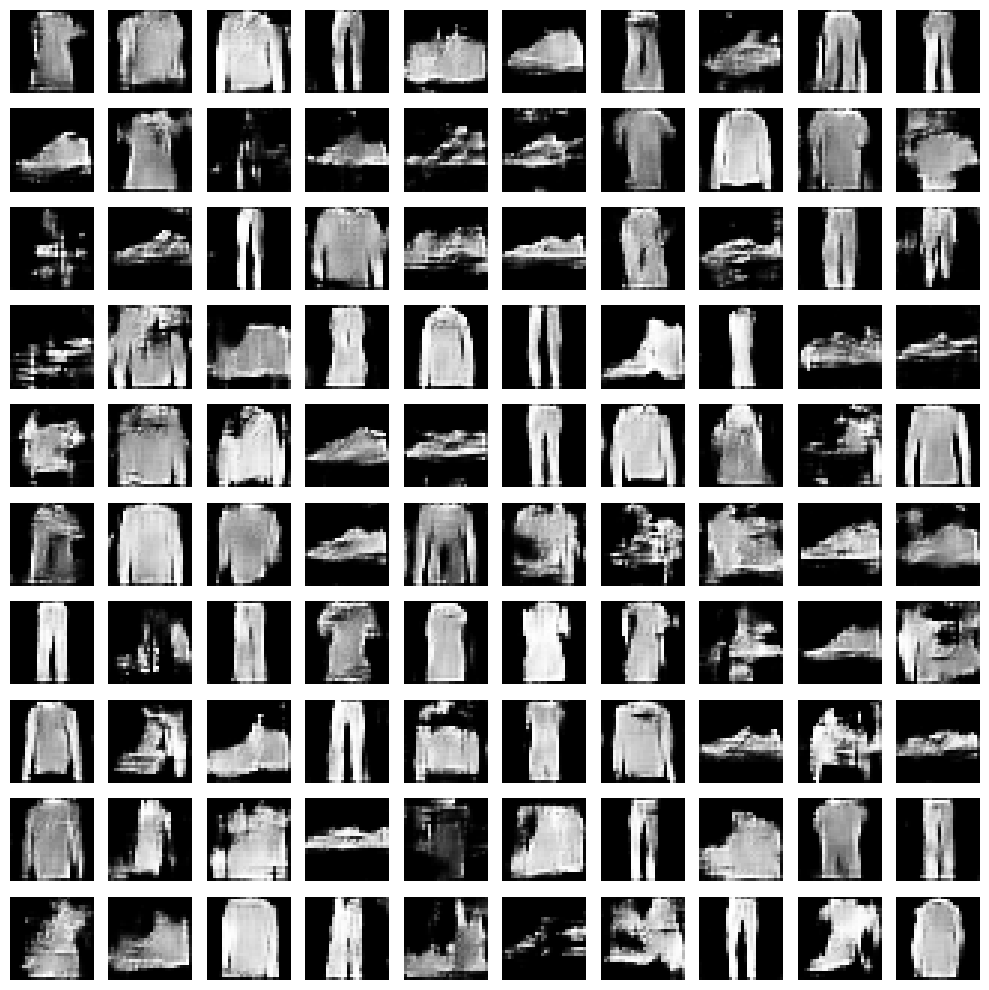

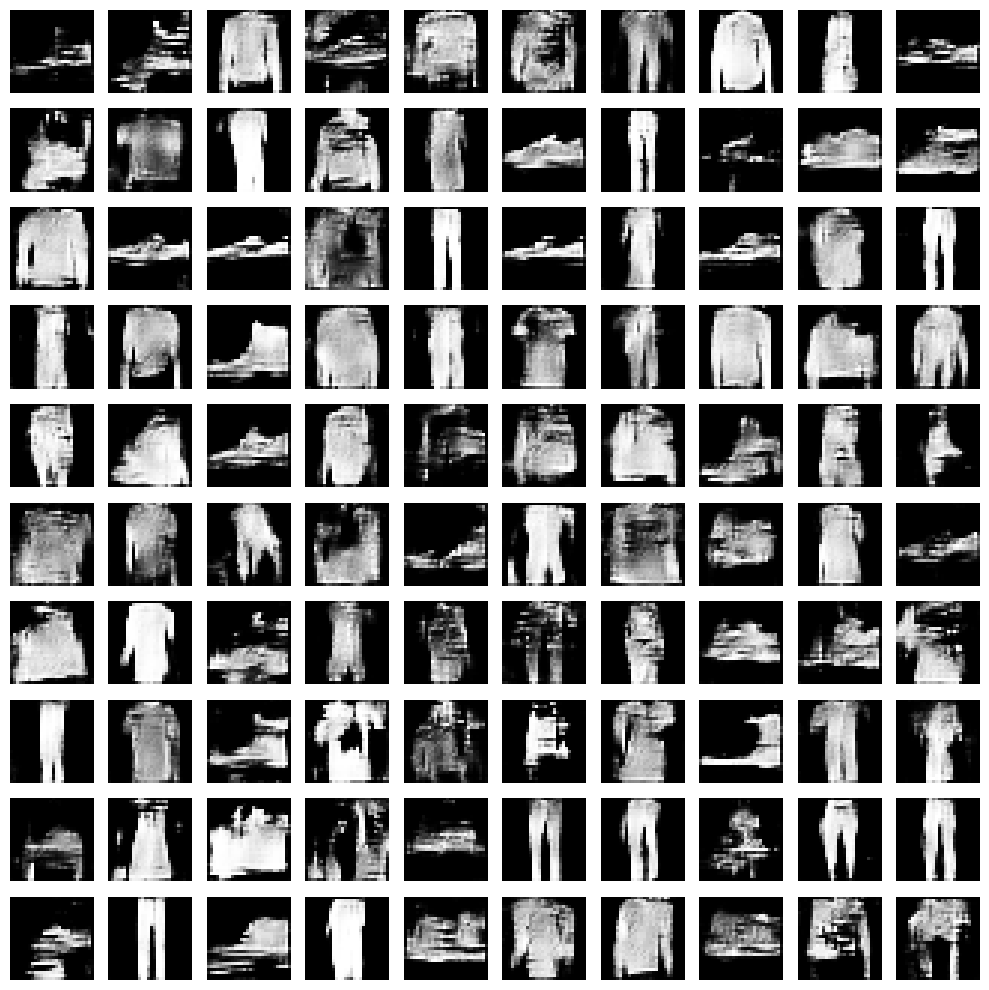

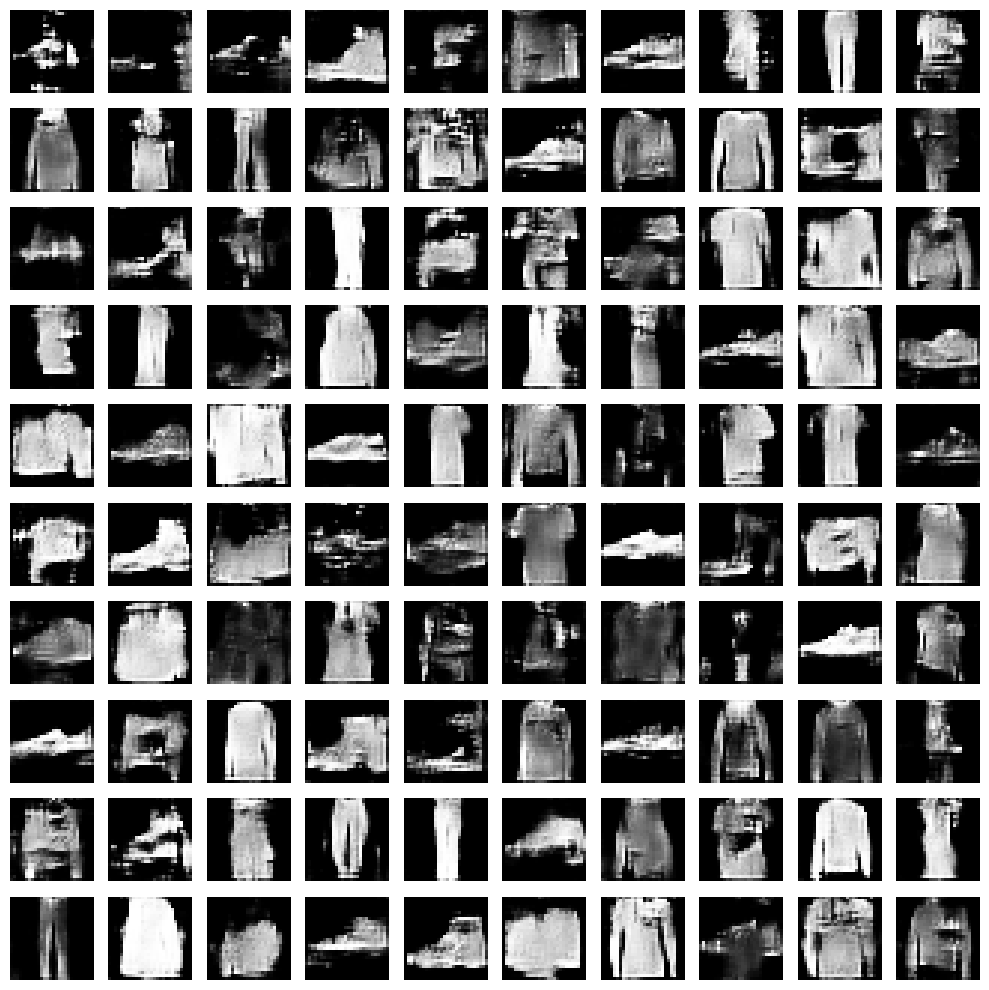

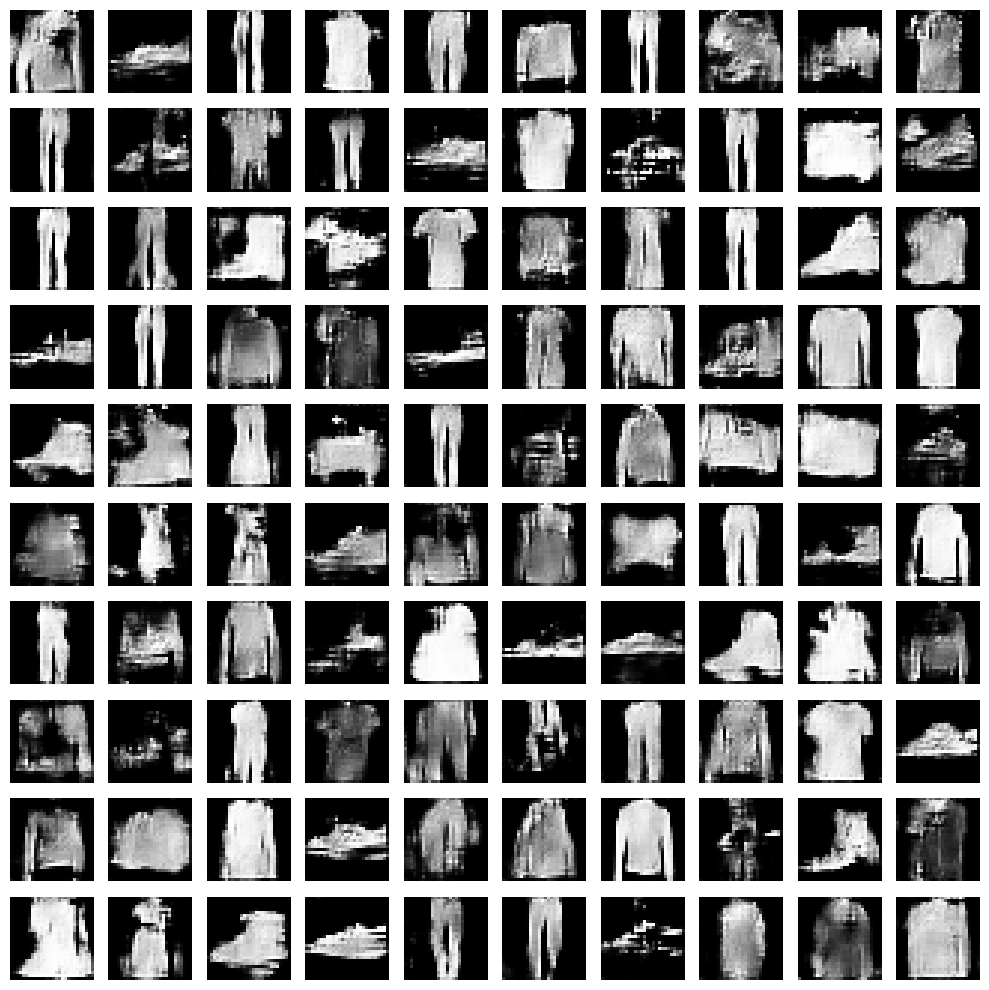

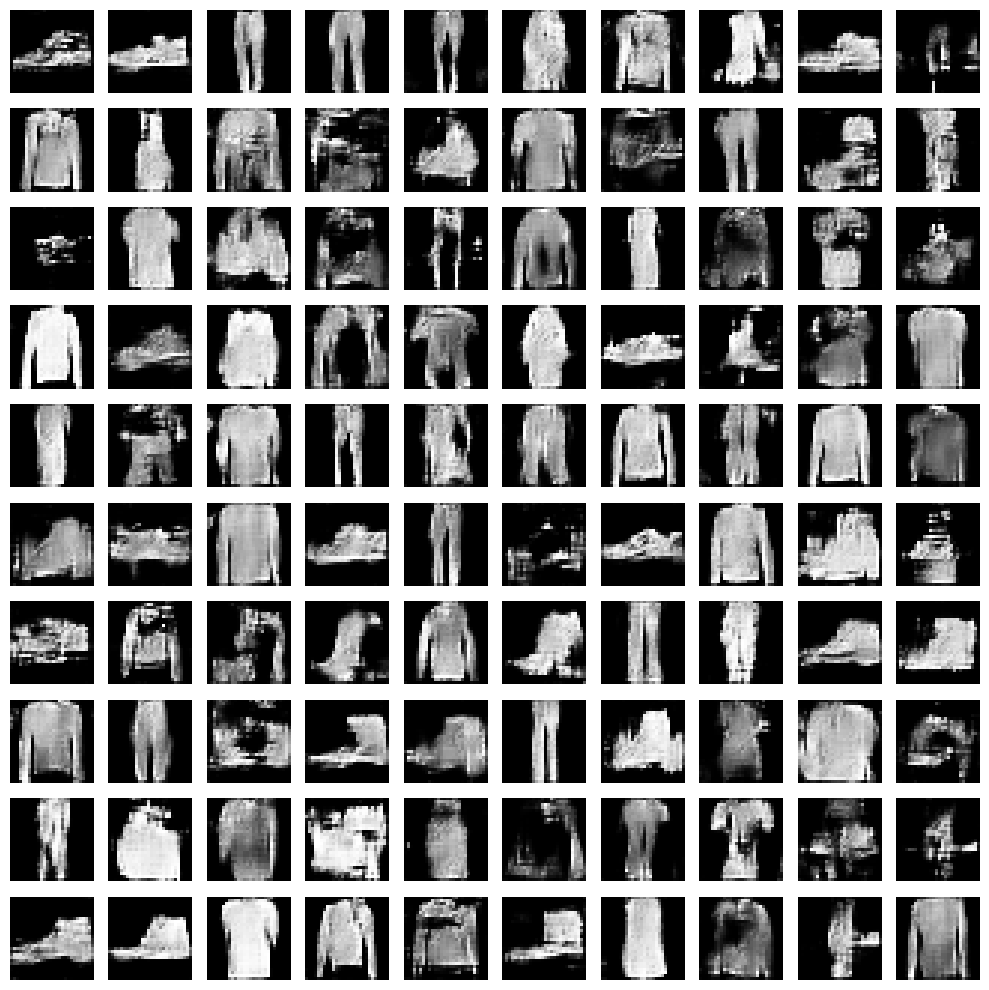

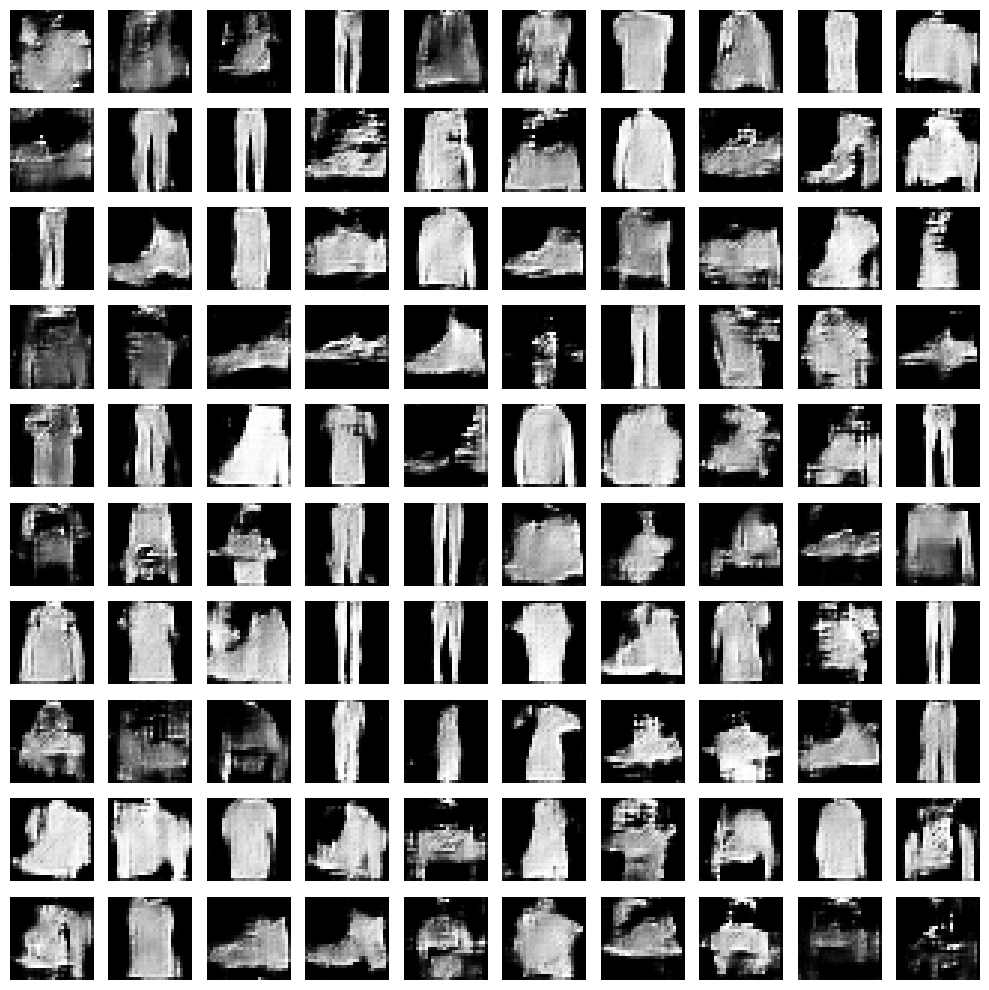

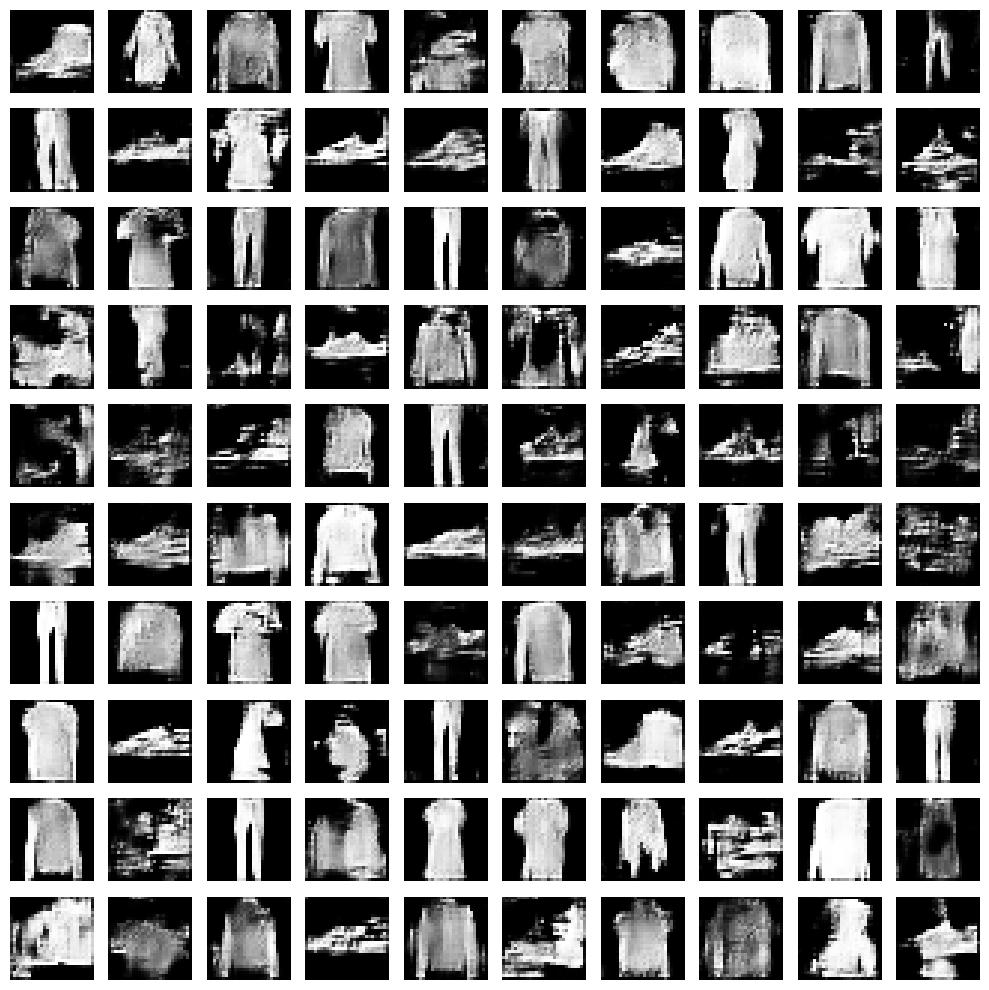

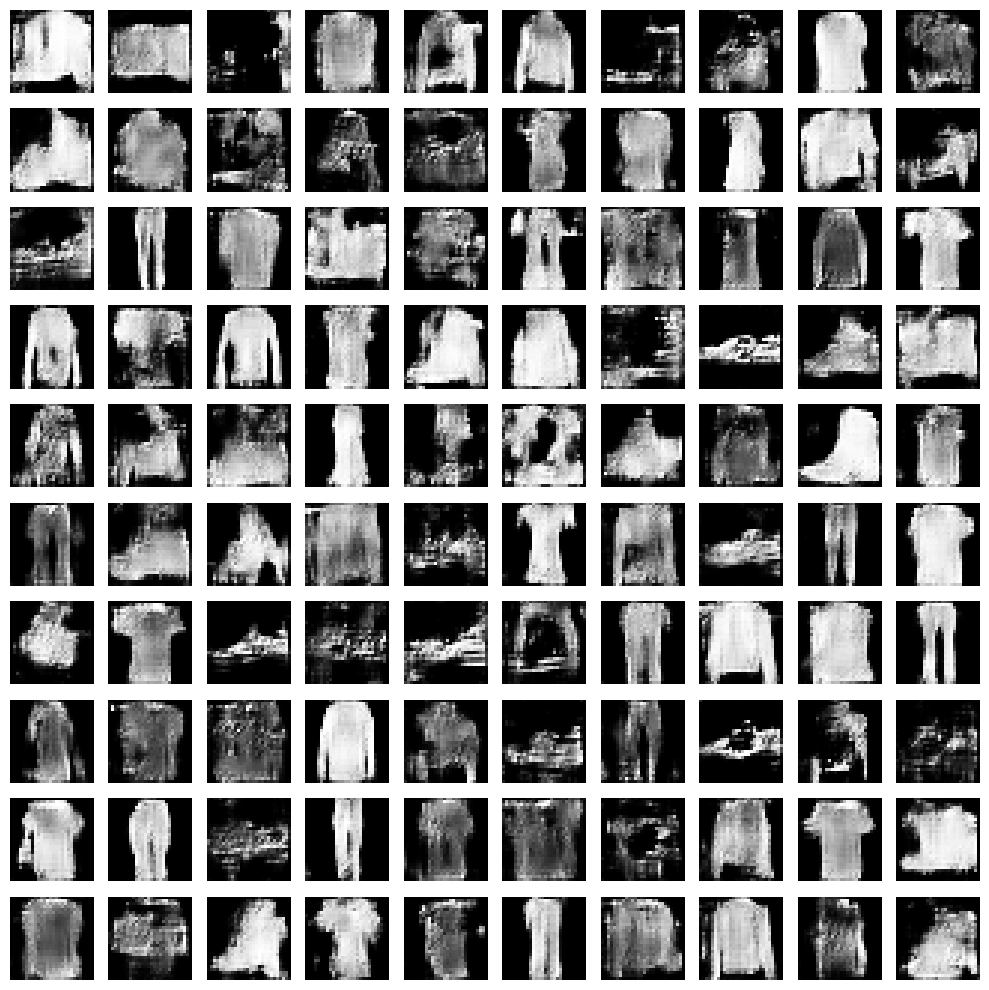

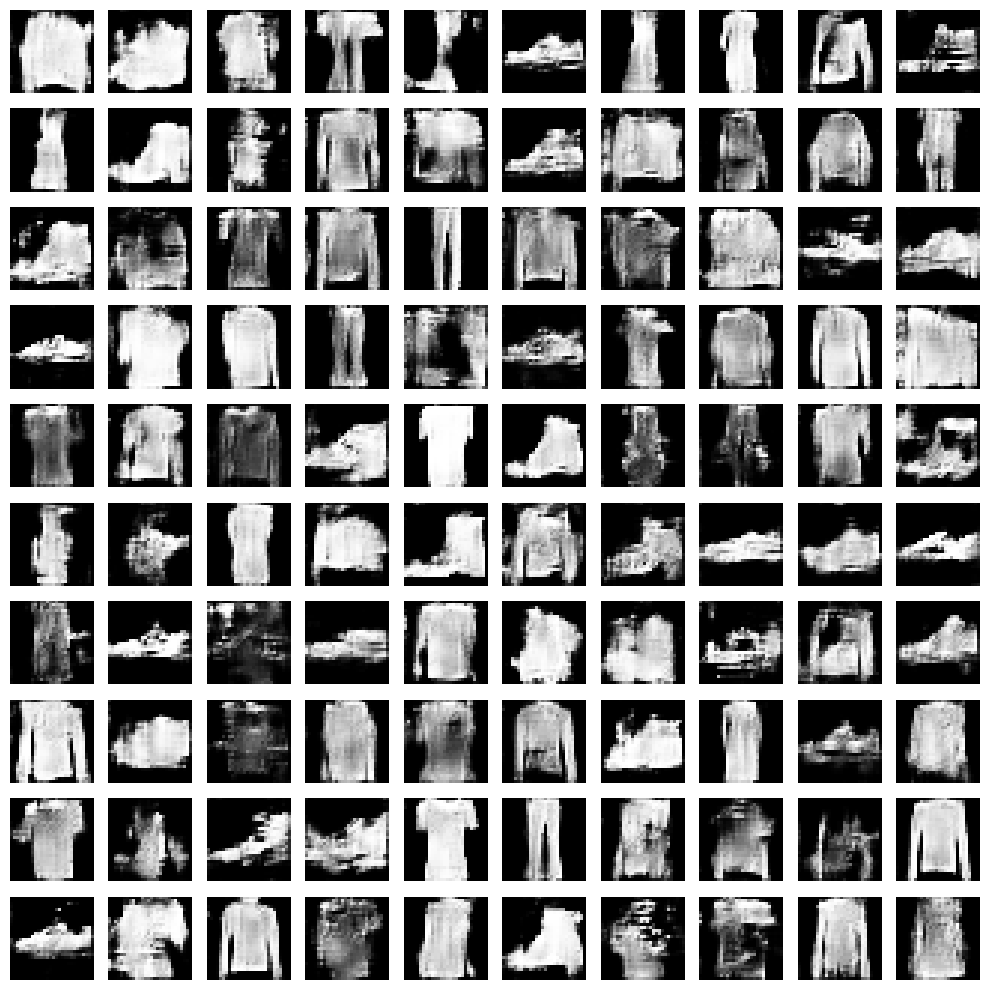

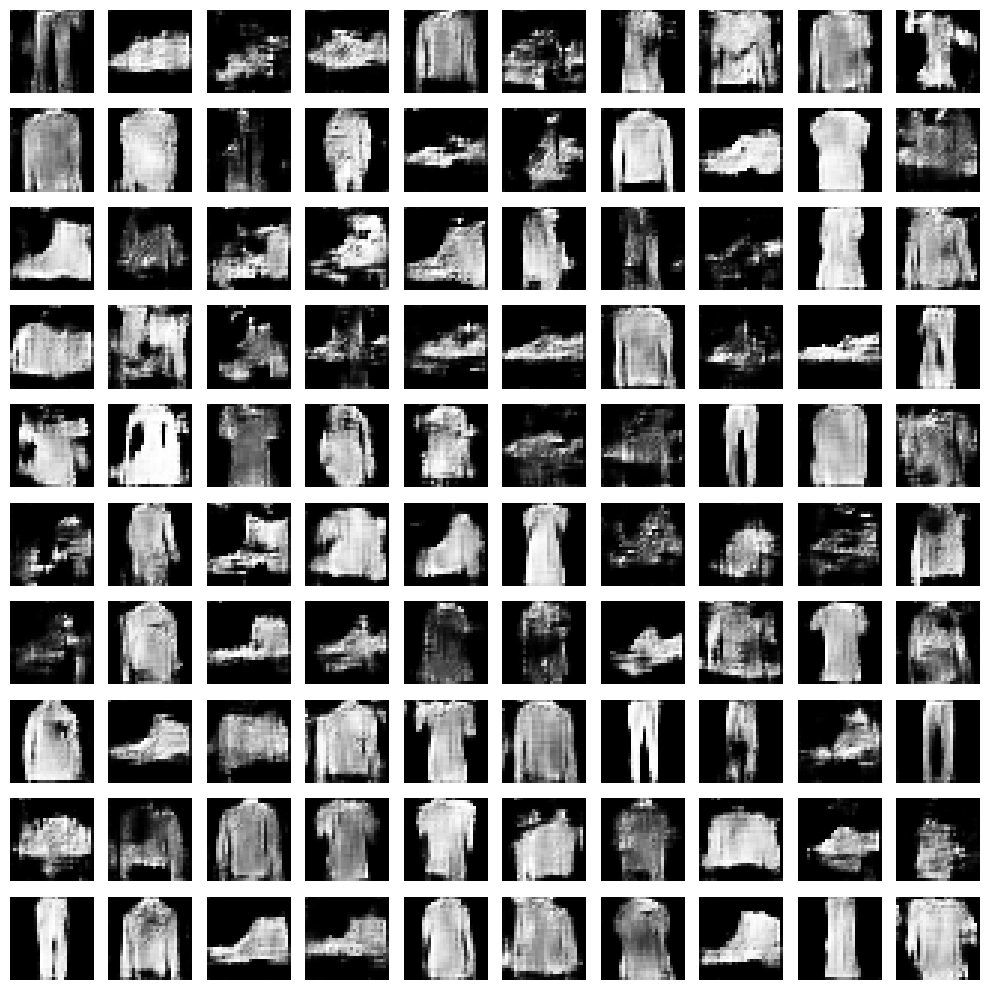

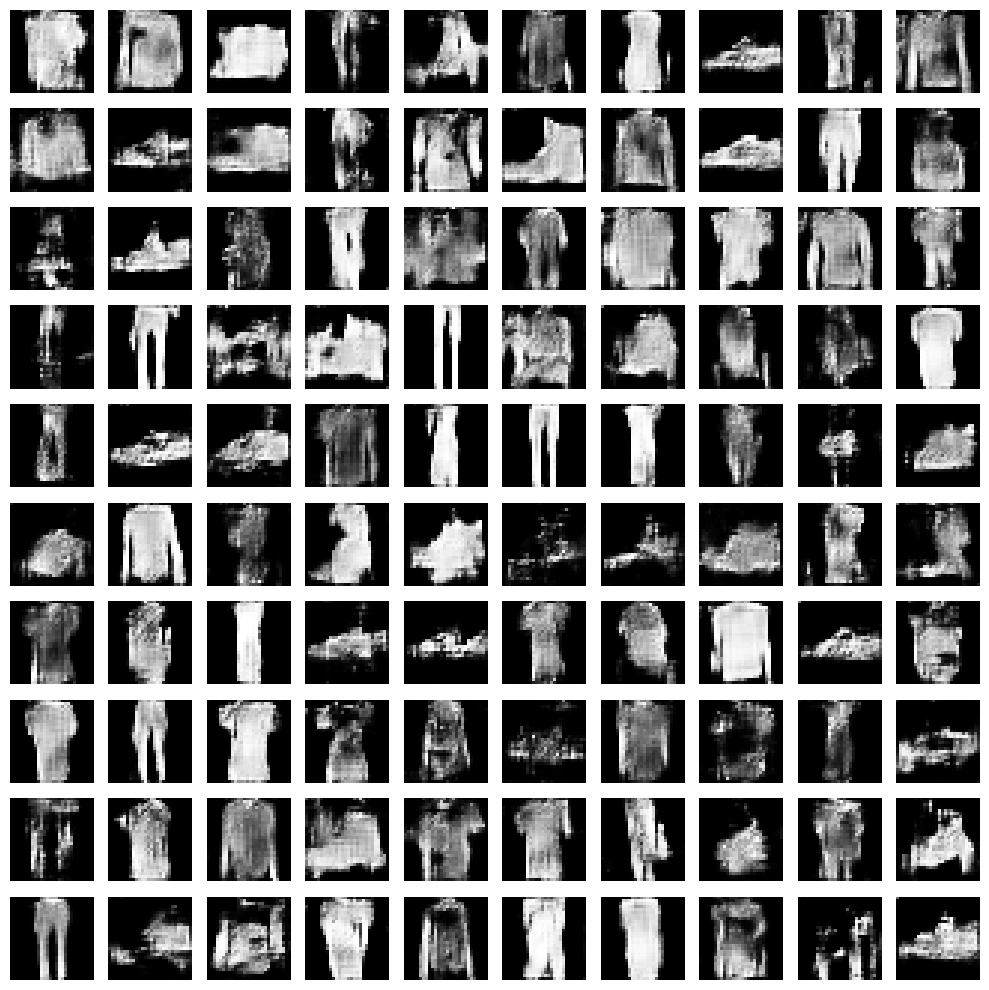

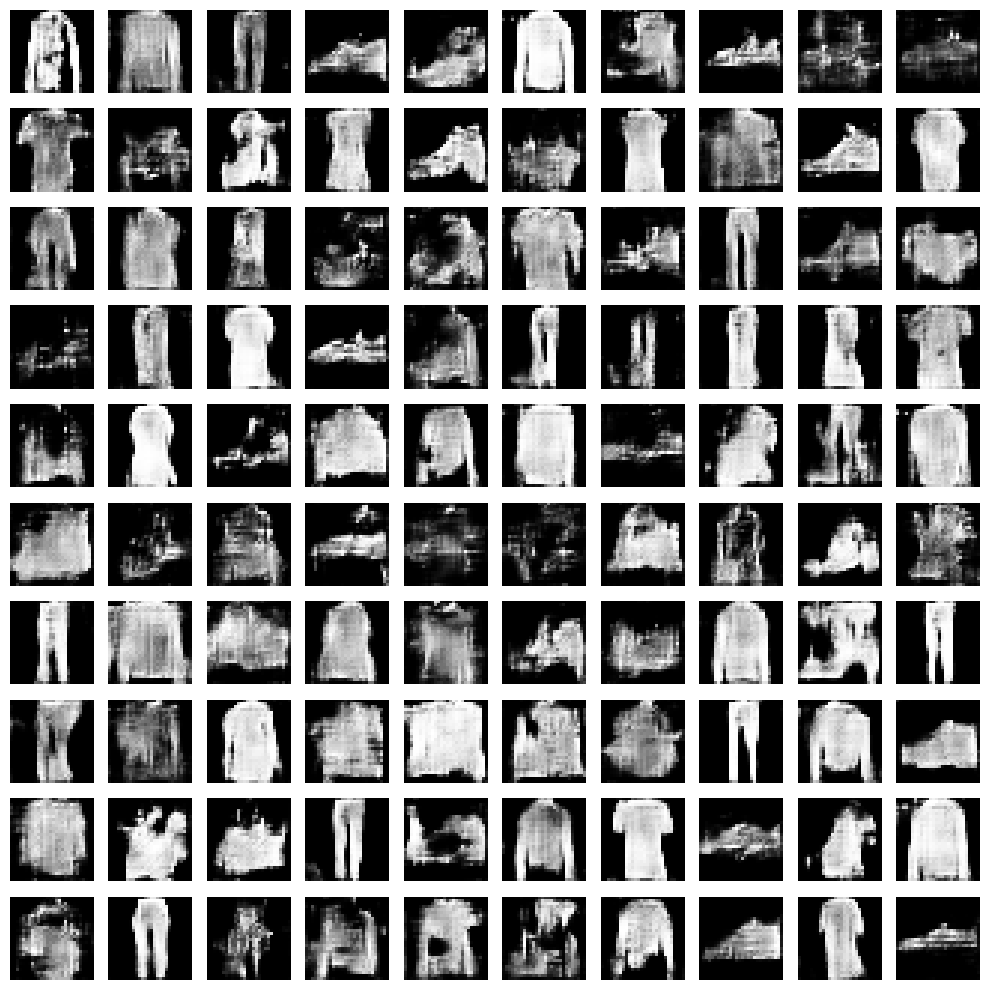

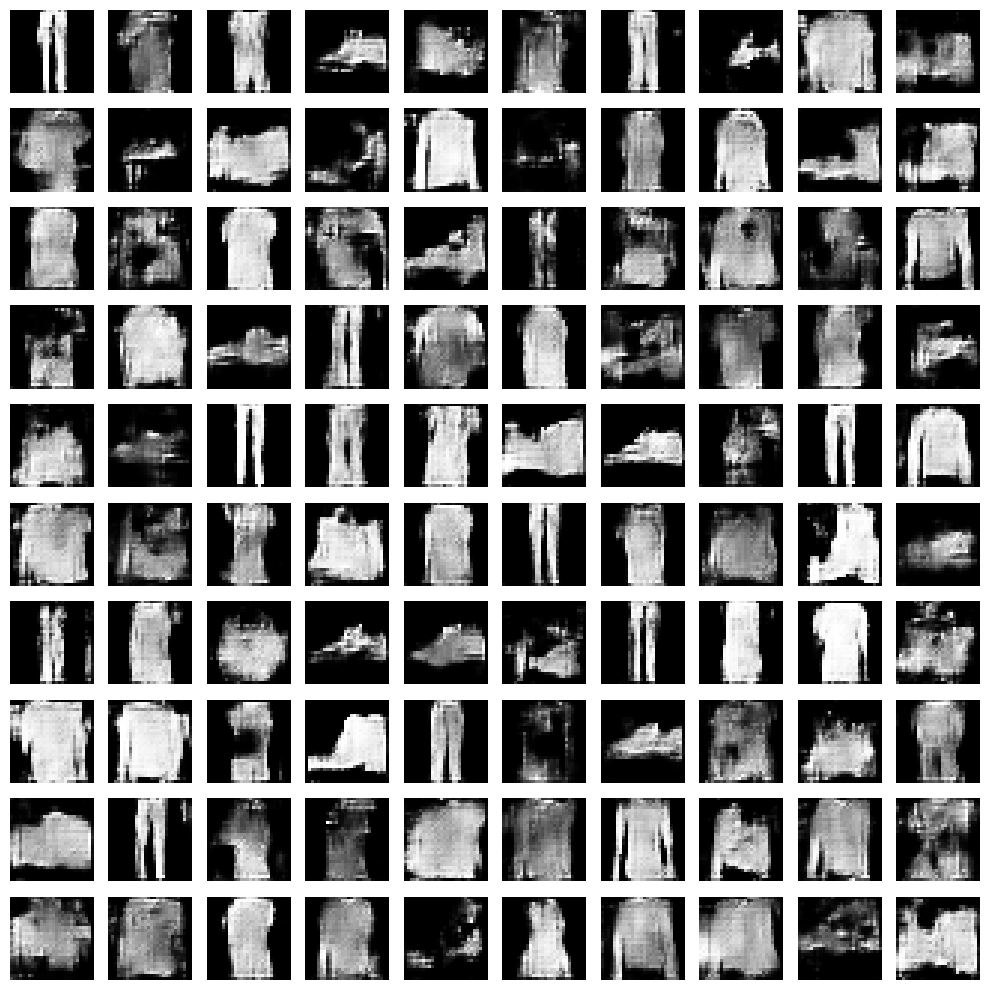

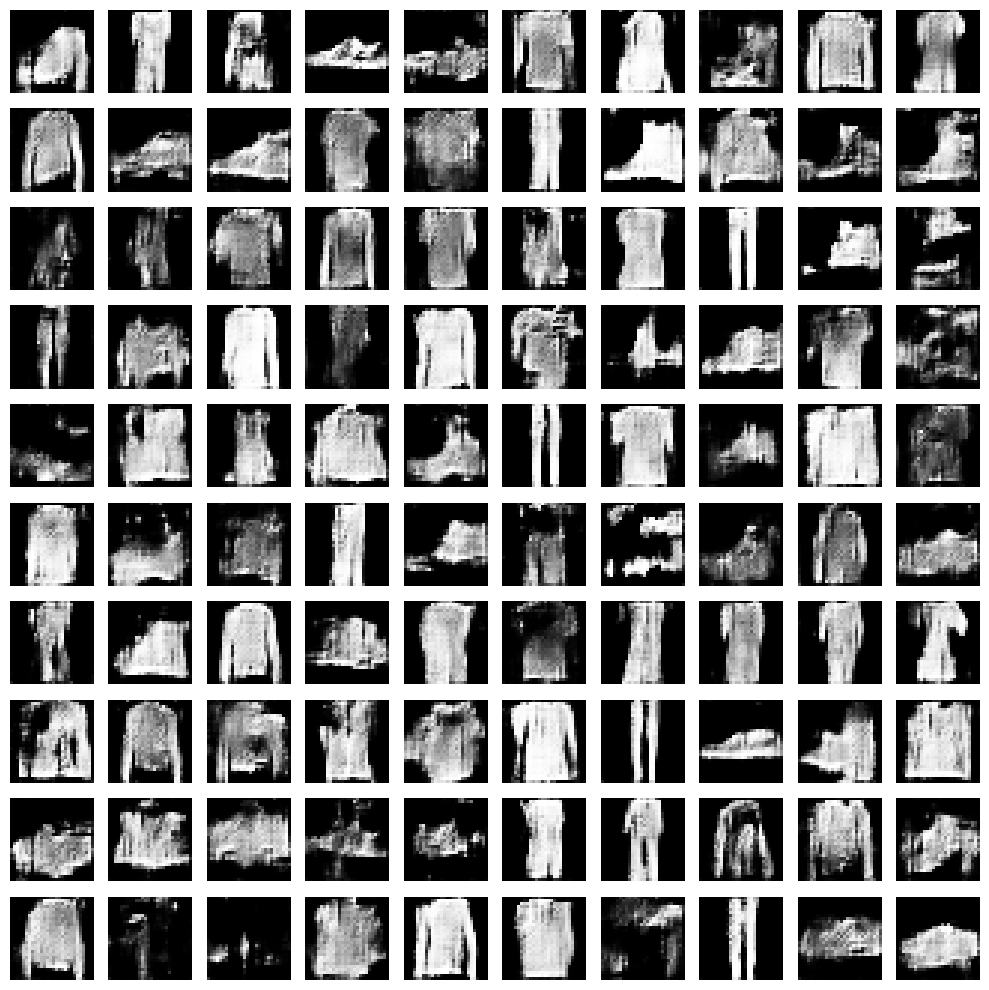

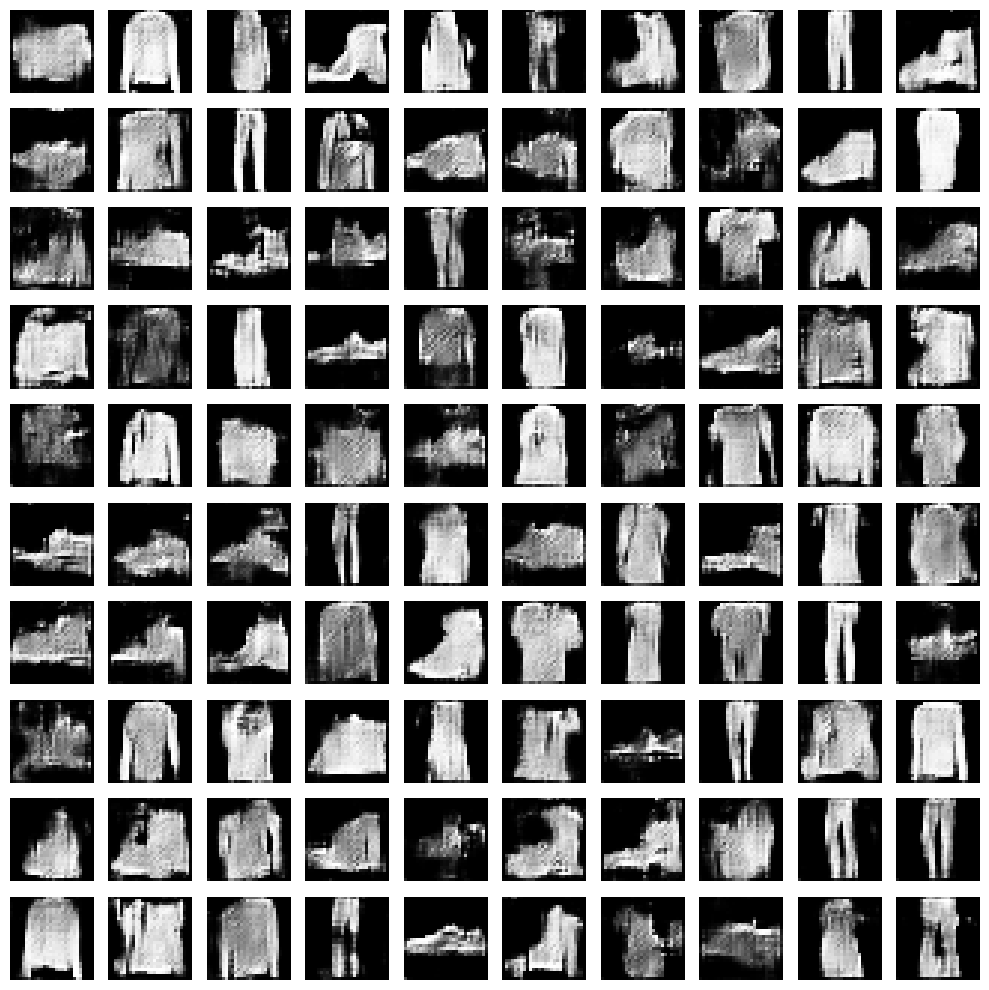

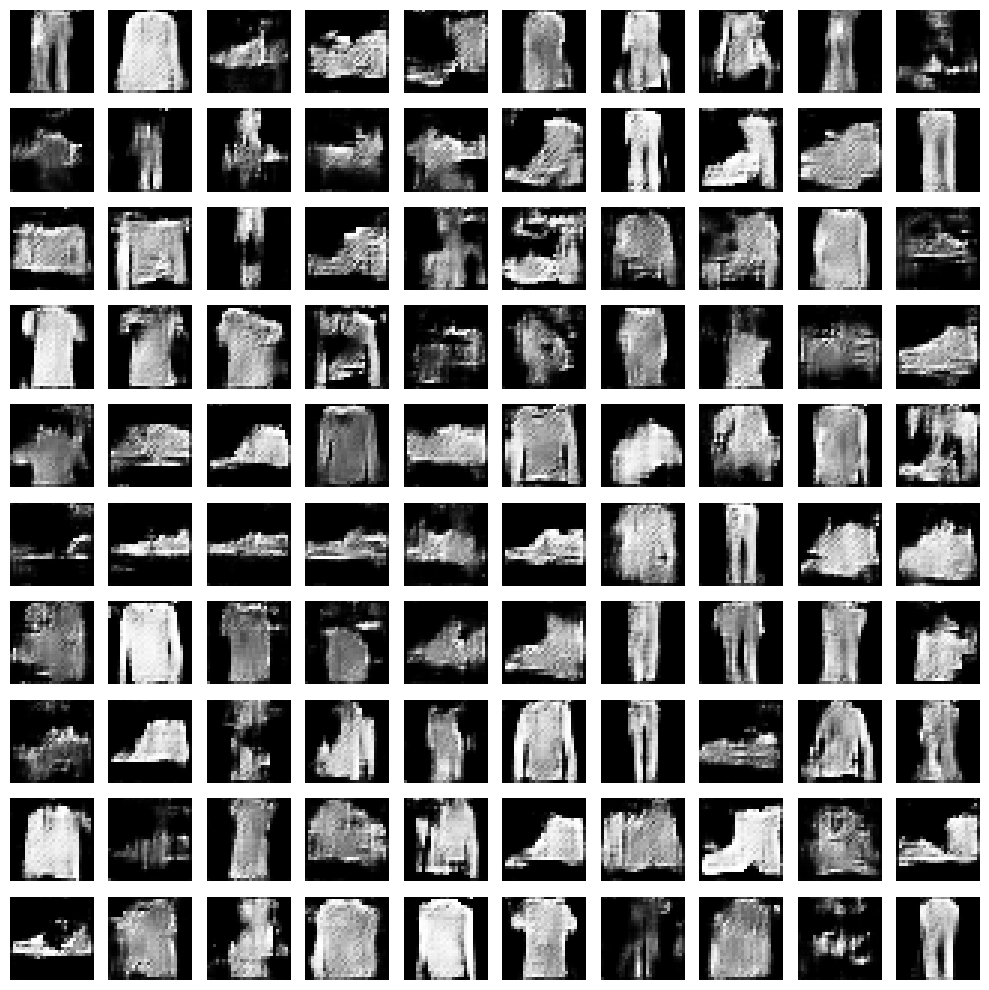

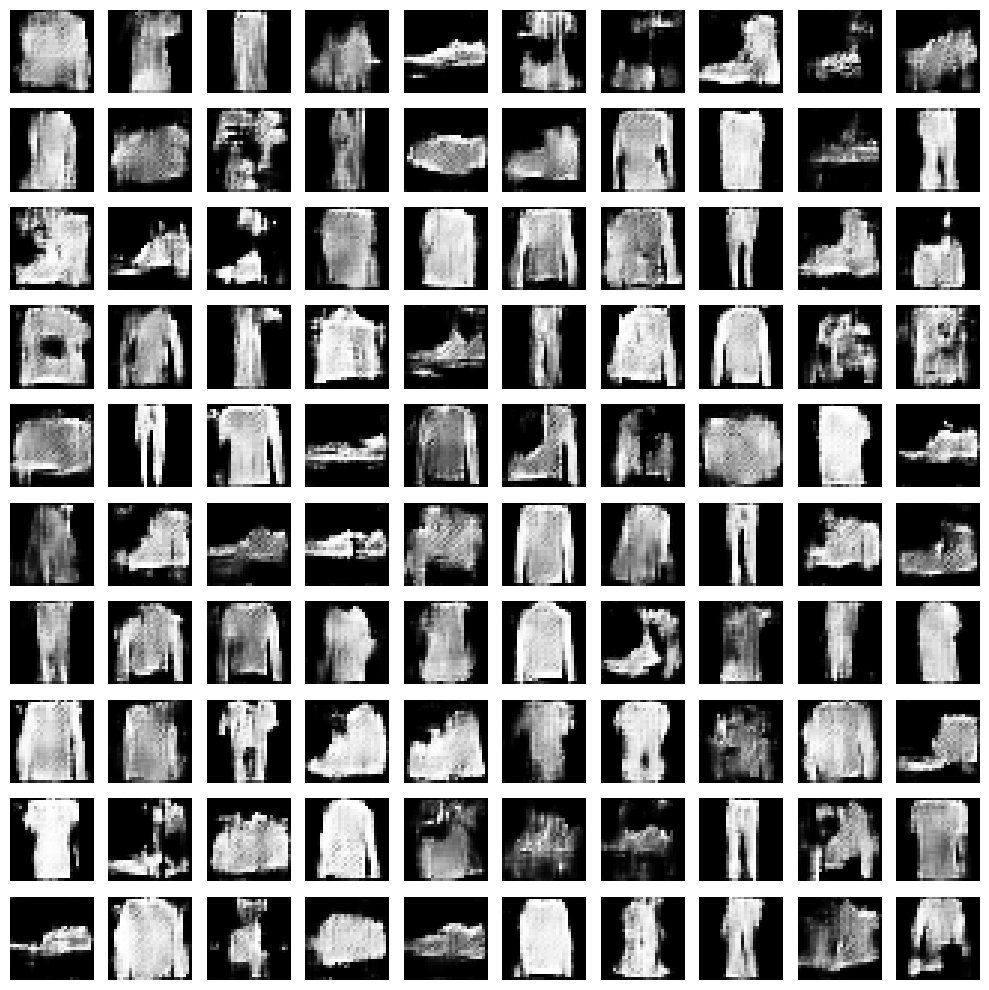

In [ ]:
train(epochs=20_000, batch_size=32, save_interval=500)